# Finding Trending Words in News

# Executive Summary 
(Business Audience)

## Objective
Identify efficient and sophisticated way to find words which are trending within news articles. To accomplish this we set out to both
- Find trends within the sample dataset provided
- Demonstrate how the approach can be applied & scaled to larger datasets

## Approach
### Defining 'trending words'
Exceptional increase of mentions of a word or sequence of words in a consistent context. Main characteristics are:
- exceptional increase of mentions with respect to the overall mentions of the word 
AND
- some level of consistent context for those mentions

Statistical tests are being used in both cases to determine relevance. A number of different approaches for building time series are used and compared for their performance (accuracy/F1) against small set of hand labeled data

### Data
- Covers ca 8000 news messages over 3 days in 16 Languages 
- Removing duplicate news and system messages, leaves about 1100 unique English articles

## Results
### Trending topics found in the data
Trends were found on topics/words such as:
- Ratings Moody
- India
- China PMI
- Soccer Wins Japan 

Observations from the models:
- Accuracy can be up to 90% depending on dataset and approach
- Using LDA for building topics allows to combine sevaral co-occurring words into a topic and has decent performance, therefore preferred method for demonstrations
- Below, we see some sample trending topics from LDA model. Those are found within the data, using our approach and confirmed as trending by the manual labels too. 

Benefits from this approach (considering e.g. samples below)
- We see definite spikes significantly above overall average levels 
- We can also see that those are active for a while and sunsequently lose momentum
- Finally, the LDA appraoch allows us to deduce some level of meaning from the topics, eg: "China PMI" or "Rating Moody .."

NB: all charts in this document provide sets of 5 time series per line which cover the whole dataset history (ca 3days) at 5min intervalls, at a 12 interval rolling sum for smootheness

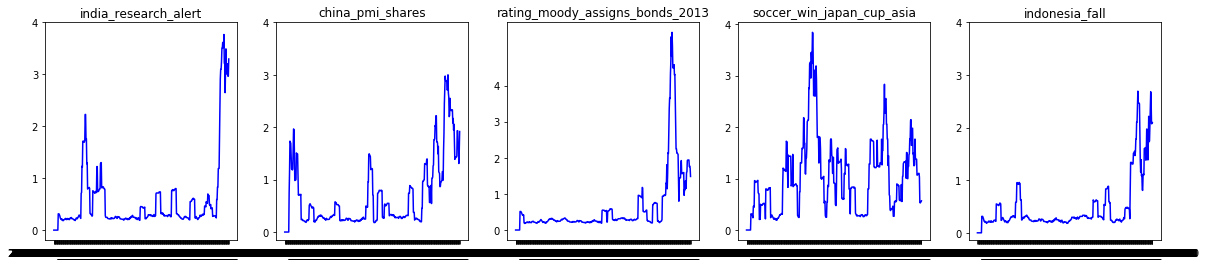

In [10]:
### NB: Run all cells marked MVP before you run this to get this result
_,df_agg=ev.pipe_transform(df_unq_en,pipe_ttl,time_interval=5)
pp.make_plt(df_agg.rolling(12).sum().fillna(0),true_pos,[], chart_scale=[4,5])


### Approach to identifying trending words
As the data is inherently unsupervised and the 'trending' quality is somewhat subjective, our approach does not provide the definitive solution, but a framework for identifying trends that match well a specific definition and does not rely on labeled data. The model uses statistical metrics for stationarity and topic homogeneity. 

However, we have labeled a small dataset for evaluaton purposes which validates results at a high level. Meaning that the model can generally be used to highlight likely trends with the aid of some additional heuristics an/or additional statistics


================================= END EXECUTIVE SUMMARY =================================

## Technical Summary
(Technical i.e. Data Science Audience)

### Summary of evaluation approach
Aim is to show time series with trending words or word-ngrams. The approach focuses on:
 1. High internal similarity (ie fairly homogeneous group of items, ie topic-like behavior) 
     - Intuition: For a topic /word to be trending it would be relevant that it is trending from the same context. For example if "American" has high frequency because of mixed usage in the context of "American Idol" the music show and "American Exports". Mixing the two into one trend will be confusing the context. Therefore articles of a topic should have high internal similarity.
     - Approach: t-test on signifant difference in cosine similarity. t-test for statistical significance between mean of the overall distribution of cosine similarities between all articles and mean of the distribution of simlarity between articles of a given topic. 
 2. Time Series Stationarity (looking for marked change in behavior /structural breaks)
     - Intuition: Significant changes to frequency of usage imply there is likely an underlying event driving this
     - Approach: Augmented Dickey Fuller test for time series stationarity, where the null hypothesis is the presence of unit root (non-stationarity). Inability to reject the null is considered indication of terending topics
 3. Use of Article Titles: We argue that trending words would come from article titles as opposed to article body. As trends in words from article body would often be due to pure style of writing within the articles and can hence confuse the trend analysis
 4. Ground Truth: To evaluate the results, there is no actual ground truth, the approach is tested against a small number of manually labelled ground truth of 
    - Top 30: most frequent words in the whole dataset (total count)
    - Spike 30: highest spiking words in the dataset (highest mentions within a 2hr rolling period)
    - LDA 30: For LDA analysis, model has been fit on 30 topics and those have been hand labeled for trendiness as they do not match with an actual list of words

### High level description of pipeline
- Preprocessing: Some clean up done based on EDA (see steps on pre-processing below)
- Transformation: In order to identify trends, have considered basic counts, tf-idf and bucketed into 5min time_intervals for consistent time
- Evaluation:
    - Tests for internal similarity of a trending word: t-test performed between the overall cosine similary of all article pairs in the data vs all articles where the word is mention in their title
    - Tests for stationarity: Augmented Dickey Fuller test, tests for time series stationarity like trends in the series (ie unit roots) tests applied on a rolling time series of titlle mentions, either via TfIdf, Counts

### Summary of experiments conducted
Experiments conducted on using different vectorizers: count, tf-idf and lda. 
- Stationarity tests: Augmented Dickey Fuller test on the time series, performed on article titles only 
- Similarity tests: t-tests on both article body and article titles. Alternating different vectorizers

Conclusions: 
- all attempts to use count and tf-idf approaches lead to essentially the same results. 
- Results vary quite significantly between Top 30 and Spike 30
- Using LDA provides good results, combined with the fact that it easily summarizes topics for us this makes for a preferred solution


|Series Stationarity|Article Similarity|Top 30 (Acc/F1)|Spike 30 (Acc/F1)| LDA 30 (Acc/F1)|
|---|---|---|---|---|
|Headline & count|Headline & count|73% / 67%|90%/93%|-|
|Headline & count|Headline & tfidf|73% / 67%|90%/93%|-|
|Headline & count|Body & tfidf|73% / 67%|90%/93%|-|
|Headline & tfidf|Body & tfidf|73% / 67%|90%/93%|-|
|Headline & lda|Body & count|-|-|83%/84%|
|Headline & lda|Headline & tfidf|-|-|83%/84%|
|Headline & lda|Body & tfidf|-|-|53%/12%|
|Headline & lda|Headline & lda|-|-|83%/84%|
|Headline & lda|Body & lda|-|-|83%/84%|


================================= END TECHNICAL SUMMARY =================================



## Detail on pipeline steps
|#|Stage|Step|Description|Outcome|Alternatives Considered|Relevant code|
|---|---|----|-----------|-------|-----------------------|-------------|
|1|Preprocessing|Remove by starting text|Articles starting with "Top news" are summaries so will distort trend statistics. Articles starting with "Test" are admin| 1010 articles removed | - | rm_rows_starting|
|2|Preprocessing|Remove by type of event|Event type "delete" removed, Story type "D" are service alerts and notify status of feed, hence both noth relevant | 1120 articles removed | - | rm_values_by_flag|
|3|Preprocessing|Merge Article Body| ACCUMULATED_STORY_TEXT & TAKE_TEXT seem to be mutually completing so merged and separete fields were dropped, minor clean up done | - | - | mrg_cols, clean_txt|
|4|Preprocessing|Group by unique ID| PNAC field provides unique IDs for all articles | ca 3600 duplicates removed, ca 2600 remain | Use 'Unique_story_index' however both approaches roughly halve the article population |group_by_id|
|5|Preprocessing|Restict to English| Use only English language articles. While a significant number of articles is dropped, the actual impact is negligible as most languages have very few articles - 16 languages have as many as English alone | ca 1200 duplicates remain | Using all languages, however, results should be independent of language and English lends itself to easier interpretation |-|
|6|Modelling|Clean up| Some removal of punctuation,etc | - | - |-|
|7|Modelling|Word vectorization| Tokenization and use of 3 types of vectorizers: simple counts, Tf-Idf and LDA to formulate word time series | - | 1. NER can help remove some of the obviously repetitive and generic words & mentions of numbers \n 2. Lemmatisation can help aggregate similar words \n 3. Word/Sentence Embeddings for finer semantic attribution |TrainPipe,Vectorizer, spacy_tokenizer, LDAVectorizer, TfIdfVectorizer, CountVectorizer|
|8|Modelling|Interval bucketing| Results bucketed further into 5min minute interval for consistent time units. Aggregation can be done either as a max or a sum frequency, where sum is prefered for counts and amx for TfIdf | - | Different time periods can be experimented with for optimal results |md.TrainPipe,TimeBuckets|
|9|Prediction|Prediction| Positive labels are given to words which cannot reject the Dickey Fuller Test of Unit root and reject a T-test of similar correlation distributions | - | Can convert the predictor to a rolling value and predict "trending" flag as a function of both word and timepoint |md.TrainPipe|
|10|Evaluation|Accuracy/F1| Measure accuracy aganst a small number of hand labeled values from the most frequent words used | - | Trends as a function of time would require more granular hand labelling to retain the ability to quantify performance of each setup |ev.get_ground_truths,ev.pipe_predict|





## Discussion of choices
### The Dickey Fuller test 
- The benefit of using the test is that it gives a statistical metric for aut
- The null hypothesis there is the presence of a unit root, ie each event influences the next one. However, here we are performing the test on rolling sums of wrod mentions. Therefore the accuracy of the test is somewhat impaired. The rolling sums approach is used as in most cases the data is extremely inoisy without some level of smoothing
- Some alternatives to the Dickey-Fuller test that can be appropriate here are 
     - the Chow test for structural breaks. However, it requires a known point where the break might be happening
     - T-test between distributions, eg long term distribtion vs some rolling distribution. However, it requires normal distributions of the underlyings while those are Poisson distributed here
     
### The T-test use for correlation distributions. 
- Helpful as provides a statistical metric
- Concerns around the assumption of normality of the underlying. Oftern correlation distributions exhibit beta distribution which makes the test potentially invalid
    
### On Embeddings and Transformer architectures (eg BERT)
There is still a lot of use that can be had from these. For instance:
- Word level embeddings can help find semantically meaningful trends. They can be used to find words with high cosine similarity (ie >95%) to identify synonyms and essentially equivalent words to improve the quality of aggregated individual words, eg cases like "America", "USA" , "the US" , etc will collase into one instance and help significantly in finding trends without using explainability
- Sentence level embeddings via eg BERT can be used to assess how homogeneous are collections of articles assigned to a trend. Similar to the solution here where cosine similarity of tf-idf on article bodies is leveraged, one can use sentence level embeddings for artcile titles and compare those instead or as a reinforcing indicator
- Sentence level embeddings can be used to stop article title duplication. Again, by observing high cosine similarity
- One shortcoming of sentence level embeddings could be some loss of interpretability. If used to build classifiers for trends (eg based on some weak supervision or small number of hand labeled examples) explainability might be lost in the inability to assign the sentence to a specific word which triggered the label

================================= END DISCUSSION =================================

In [1]:
################ MVP ################
%load_ext autoreload

In [2]:
################ MVP ################

%matplotlib inline
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
%autoreload 2
import source.preprocess as pp
import source.modelling as md
import source.evaluation as ev

### Read in data

In [3]:
################ MVP ################
df=pd.read_csv('./raw_data/rna002_RTRS_2017_11_29.csv',
               engine='python', encoding='utf-8',error_bad_lines=False).fillna('')

Skipping line 8132: unexpected end of data


### Observations from summary stats: 
- PNAC can be used as a seemingly reliable identifier of unique news, as the title is often the same across multiple articles of the same ID. Whenever the content changes to the same PNAC it tends to be an expansion to the original one
- "Related_RICS" & "NAMED_ITEMS" refer to financial instruments (stocks/tickers) mentioned in the news article. Before clean up only about 20% of news have a value in "Related_RICS" after clean up this goes to about 33% but still the predominant part of news is not marked as related to a company
- Very partial coverage of article bodies (see % Available) ACCUMULATED_STORY_TEXT & TAKE_TEXT
- Using Story type flag 'D' we can remove Service alerts, ie Suspension/Resumption/Maintenance of Reuters services alerts
- 'Attribution' in this data is always 'Reuters', the correct approach to reuse would be to have an alert for any other attribution types. Consider also filtering to only provide results where attribution is "Reuters"


In [4]:
pp.summary_stats(df, max_smpl=2)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
DATE,3,0,0,8130,100.0,object,"[2013-06-02, 2013-06-01]"
TIME,7012,0,0,8130,100.0,object,"[13:49:42.748, 08:04:24.324]"
UNIQUE_STORY_INDEX,3707,0,0,8130,100.0,object,"[20130602160000nEAP51Z2QO, 20130602122116nL5N0EE0CN]"
EVENT_TYPE,5,0,0,8130,100.0,object,"[STORY_TAKE_OVERWRITE, ALERT]"
PNAC,2797,0,0,8130,100.0,object,"[nL5N0ED0MI, nL5N0EE03M]"
STORY_DATE_TIME,3185,0,0,8130,100.0,object,"[2013-06-02 17:00:10, 2013-06-02 05:37:49]"
TAKE_DATE_TIME,3432,3579,0,4551,56.0,object,"[2013-06-02 14:56:15, 2013-06-02 14:21:48]"
HEADLINE_ALERT_TEXT,3262,955,0,7175,88.0,object,"[ATUALIZA 1-Sobe para 9 número de mortos por tornados em Oklahoma, SERVICE ALERT - Thomson Reuters Dealing - RESOLVED see page <ALERT14>]"
ACCUMULATED_STORY_TEXT,360,7755,0,375,5.0,object,"[ PARIS, 1 jun (Reuters) - La unidad francesa del banco suizo \nUBS <UBSN.VX> fue puesta bajo una investigación formal el \nviernes en París por una presunta complicidad en prácticas \nsospechosas de negocios en Francia, dijo una fuente judicial. \n UBS France está siendo investigada por la justicia francesa \nen relación a si ofreció a potenciales clientes franceses \ninversiones que presuntamente estaban diseñadas para evadir \nimpuestos. \n Tres ejecutivos de UBS France ya han si..."
TAKE_TEXT,3427,4551,0,3579,44.0,object,"[ 도쿄, 6월3일 (로이터) - 일본 주식시장의 니케이지수가 3일 2% 이상 하락하면서 근 6주래 최저치로 떨어졌다. 미국 증시 하락으로 그렇지 않아도 취약한 일본 증시의 투심이 더욱 흔들린 영향이다. \n \n 니케이지수는 한때 13,387.02까지 하락한 뒤 전일보다 2.17% 내린 13,475.64로 오전 거래를 마감했다. \n \n 일본 증시 급등에 따라 랠리를 펼쳐왔던 증권업종이 6.5% 하락했고, 정부의 팽창 정책의 수혜를 입을 것이라는 기대로 상승세를 보여온 부동산업종이 3.4% 내렸다. (도미닉 라우 기자) \n \n ((Reuters Messaging: \nanna.sheen.thomsonreuters.com@thomsonreuters.net)), İSTANBUL, 3 Haziran (Reuters) - \n *Başbakan Tayyip Erdoğan resmi temaslarda bulunmak üzere \..."


## Preprocessing Pipeline

Steps are described above

In [4]:
################ MVP ################
select_cols=['DATE', 'TIME', 'UNIQUE_STORY_INDEX', 'EVENT_TYPE', 'PNAC',
               'STORY_DATE_TIME', 'TAKE_DATE_TIME', 'HEADLINE_ALERT_TEXT', 
                 'ART_BODY_MERGED','NAMED_ITEMS', 
                  'TOPICS', 'RELATED_RICS', 'LANGUAGE']

df_clean=df.pipe(pp.rm_rows_starting,'HEADLINE_ALERT_TEXT',['Test, Please Ignore','*TOP NEWS*']) \
        .pipe(pp.rm_values_by_flag,'EVENT_TYPE','DELETE') \
        .pipe(pp.rm_values_by_flag,'STORY_TYPE','D') \
        .pipe(pp.mrg_cols,['ACCUMULATED_STORY_TEXT','TAKE_TEXT'],'ART_BODY_MERGED') \
        .pipe(pp.clean_txt,'ART_BODY_MERGED') \
        .pipe(pp.group_by_id,select_cols=select_cols, sort_by='ART_BODY_MERGED',group_by='PNAC')

        
print('Unique articles all languages',df_clean.shape[0])
df_unq_en=df_clean[df_clean.LANGUAGE=='EN']
print('Unique articles all english',df_unq_en.shape[0])
    

Unique articles all languages 2394
Unique articles all english 1034


In [6]:
################ MVP FINAL ################
# This is out of order with the rest of the analysis, however, this is the final cell 
# we need to run to get the results in the executive summary

# pipe_ttl - Train Article titles Pipeline
pipe_ttl=md.TrainPipe('HEADLINE_ALERT_TEXT','lda',ngram=2, min_df=5)
pipe_ttl.fit(df_unq_en,)
# pipe_art - Train Article bodies Pipeline
pipe_art=md.TrainPipe('ART_BODY_MERGED','lda',ngram=2, min_df=5)
pipe_art.fit(df_unq_en,)

# df_agg_lda - Get aggregate dataframe at 5min intervals
_,df_agg_lda=ev.pipe_transform(df_unq_en,pipe_ttl,time_interval=5)

# Needed to get the true positives for the summary table
all_titles_lda, trending_titles_lda, y_true=ev.get_ground_truths('./ground_truth/LDA30_tpcs.csv')

# Get predictions from this pipeline and merge them with the ground truth to get 5 examples
pred_lbl, df_res=ev.pipe_predict(all_titles_lda,df_unq_en, pipe_ttl,pipe_art, time_interval=5)
#true_pos=list(set(df_res[df_res.Prediction==1].index) & set(trending_titles_lda))[:5]
# These are hand selected but are labeled by the model as positive for trending
# Fixing the selection here to avoid randomness
true_pos=['india_research_alert',
          'china_pmi_shares', 
          'rating_moody_assigns_bonds_2013', 
          'soccer_win_japan_cup_asia',
          'indonesia_fall',]

################ YOU CAN NOW RUN EXECUTIVE SUMMARY CELL ################

# Observations post clean up
- Significant number of repeating articles (also confirmed by directly using UNIQUE_STORY_INDEX getting a similar number of articles)
- TAKE_DATE_TIME no longer well copulated, so will use STORY_DATE_TIME
- ART_BODY_MERGED appears to have filled all article gaps 
- NAMED_ENTIES and RELATED_RICS still very spotty population. Offline analysis has shown that there are no significant outliers in those that can point to a trend for a specific company
- Similar results on TOPICS - there seem to many topics per article however most refer to georgrapies and industries making the field not very useful. Some hand picked seemingly interesting examples: 

In [11]:
pp.summary_stats(df_unq_en, max_smpl=2)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
PNAC,1034,0,0,1034,100.0,object,"[nL3N0EE068, nEAP30A30N]"
DATE,3,0,0,1034,100.0,object,"[2013-06-03, 2013-06-01]"
TIME,1034,0,0,1034,100.0,object,"[02:23:56.549, 17:21:44.529]"
UNIQUE_STORY_INDEX,1034,0,0,1034,100.0,object,"[20130601173344nIGB335395, 20130601200154nL5N0ED0MR]"
EVENT_TYPE,4,0,0,1034,100.0,object,"[HEADLINE, STORY_TAKE_APPEND]"
STORY_DATE_TIME,989,0,0,1034,100.0,object,"[2013-06-02 15:30:45, 2013-06-03 02:43:45]"
TAKE_DATE_TIME,44,990,0,44,4.0,object,"[2013-06-02 23:35:11, 2013-06-03 04:54:55]"
HEADLINE_ALERT_TEXT,985,0,0,1034,100.0,object,"[Results of BOJ outright JGB (Residual maturity of 3YR to 5YR) buying operation, U.S. REFINERY FILING - NATIONAL RESPONSE CENTER - CHALMETTE REFINING LLC]"
ART_BODY_MERGED,1008,0,0,1034,100.0,object,[ Jun 3 (Reuters)- Below are the details of India commercial papers dealt in the primary & secondary market for May 2013. (10 million = 1 crore) - ISSUER INVESTOR MATURITY RATINGS DEALT VOLUME TRADED YTM(%) IN MLNS DATE - PRIMARY MARKET ADITYA BIRLA FIN LTD BANKS & MFS JUL & AUG 2013 ICRA A1+ 8.4700 1250 27-May-13 ADITYA BIRLA FIN LTD - 2 MONTHS ...
NAMED_ITEMS,112,862,0,172,17.0,object,"[DATA/, CHE/IN]"


## Identifying the ground truth

In order to introduce the ability to measure results against a fixed metric, we have hand labeled a small number of results. 
By running some these pipelines in the background we identified three groups of interest:
- Top 30 words by highest spike in usage within 60 mins (ie rolling sum of 12x5min period)
- Top 30 words by highest frequency of usage
- Top LDA topics: as LDA topic modelling naturally generates topics with multiple words its findings cannot be directly mapped to the single/bi-gram approach of the former two. Therefore we have separately curated the LDA list too

We have then gone back to evaluate manually where these exhibit trending behavior. Some observations:
- We would consider trending behavior to be a significant jump in usage of the word for a somewhat sustained period of time, ie not just a single spike
- When using the above rule to determine this, we find there are many common sense words which may or may not be actual trends based on this criterion. 

Below, we are seing the rolling 
Consider the images below

|Word| Behavior| Common Sense| Decision here|
|:----|:---------|:-------------|:--------------|
|india| Sudden fairly short spike | Probably event | Trending |
|update|Multiple spikes in a large range| Common word, difficult to account for common words outside a stop list| Not trending|
|june, 3 & june 3|Multiple spikes in a large range| Common word, however seems to have sudden updard trend to it| Trending|
|american power (from second set of charts)|Multiple small spikes in a small range | Not common , however, seems common here based on this data| Not Trending|

### Top 30 Short Term Spikes - Hand Labeling

22 out of the 30 top words here seem to match the description of a trending topic

The below image shows each of those 30 terms against time and highlighing the ones in RED as trending (based on manual labelling). This approach is obviously subject to further discussion and what on those grids is onsidered a trend

In [12]:
pipe_ttl=md.TrainPipe('HEADLINE_ALERT_TEXT','count',ngram=2, min_df=5)
pipe_ttl.fit(df_unq_en,)
_,df_agg=ev.pipe_transform(df_unq_en,pipe_ttl,time_interval=5)

In [13]:
all_titles_top, trending_titles_top, y_true=ev.get_ground_truths('./ground_truth/Spike30_wrds.csv')

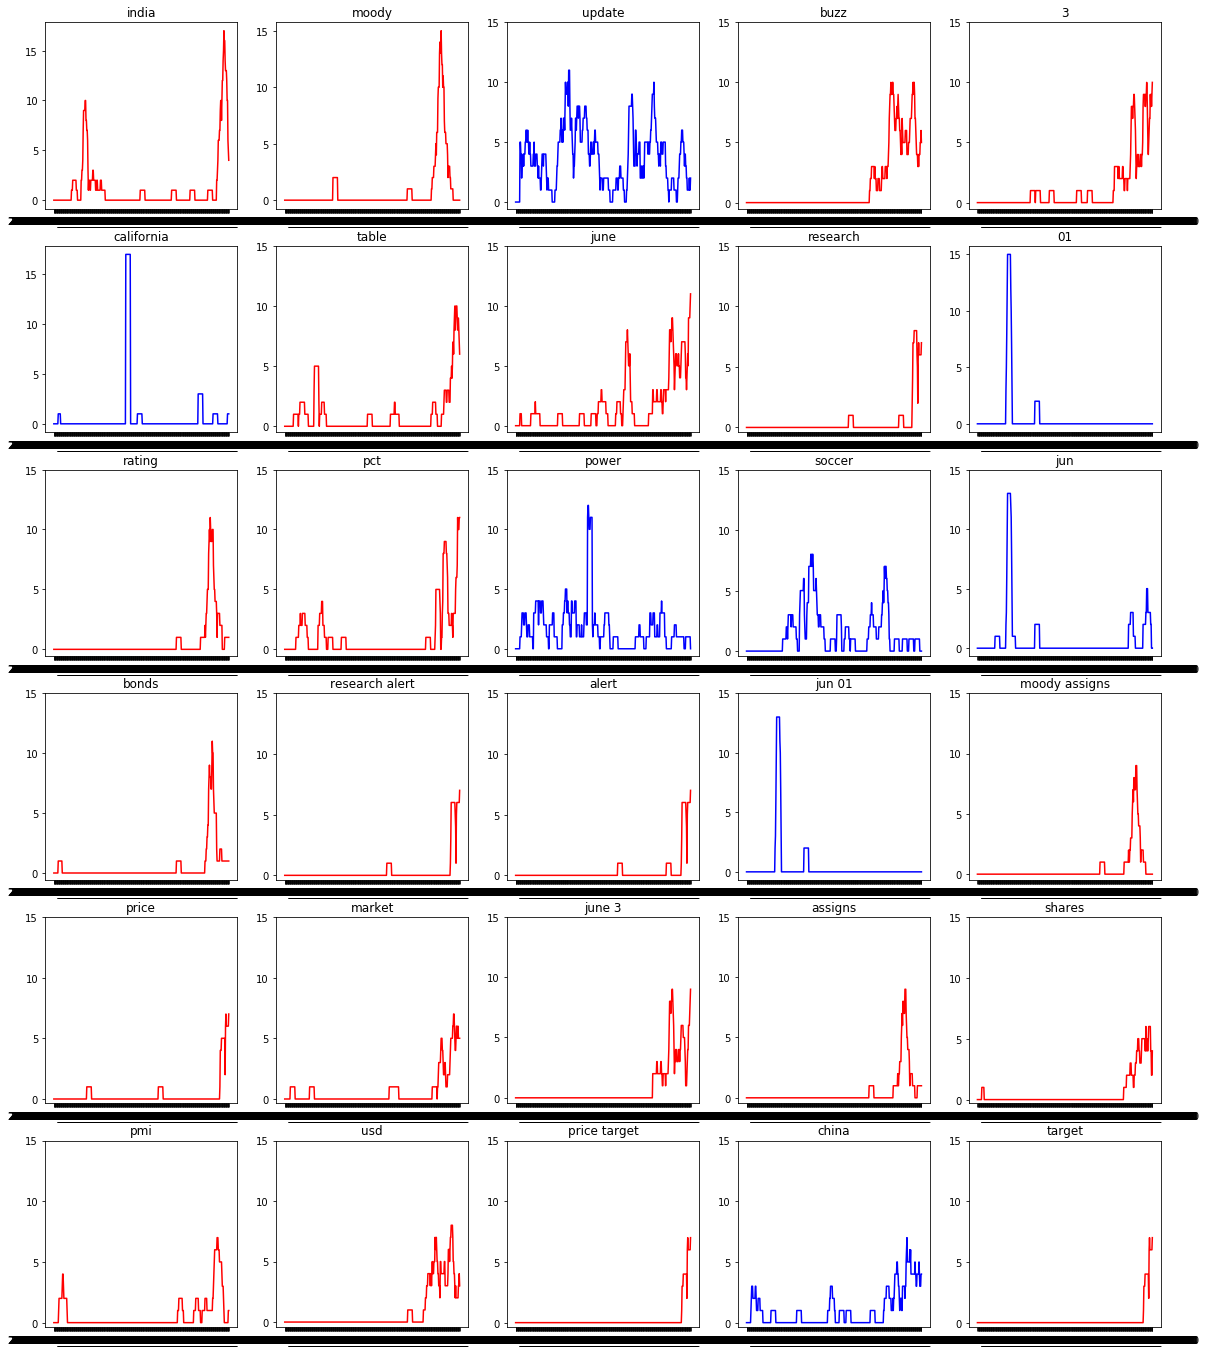

In [14]:
pp.make_plt(df_agg.rolling(12).sum().fillna(0),all_titles_top,trending_titles_top)

### Top 30 Highest Volume Words

12 out of the 30 top VOLUME words here seem to match the description of a trending topic.

The below image shows each of those 30 terms against time and highlighing the ones in RED as trending (based on manual labelling). This approach is obviously subject to further discussion and what on those grids is onsidered a trend

In [15]:
all_titles_vol, trending_titles_vol, y_true=ev.get_ground_truths('./ground_truth/Top30_wrds.csv')

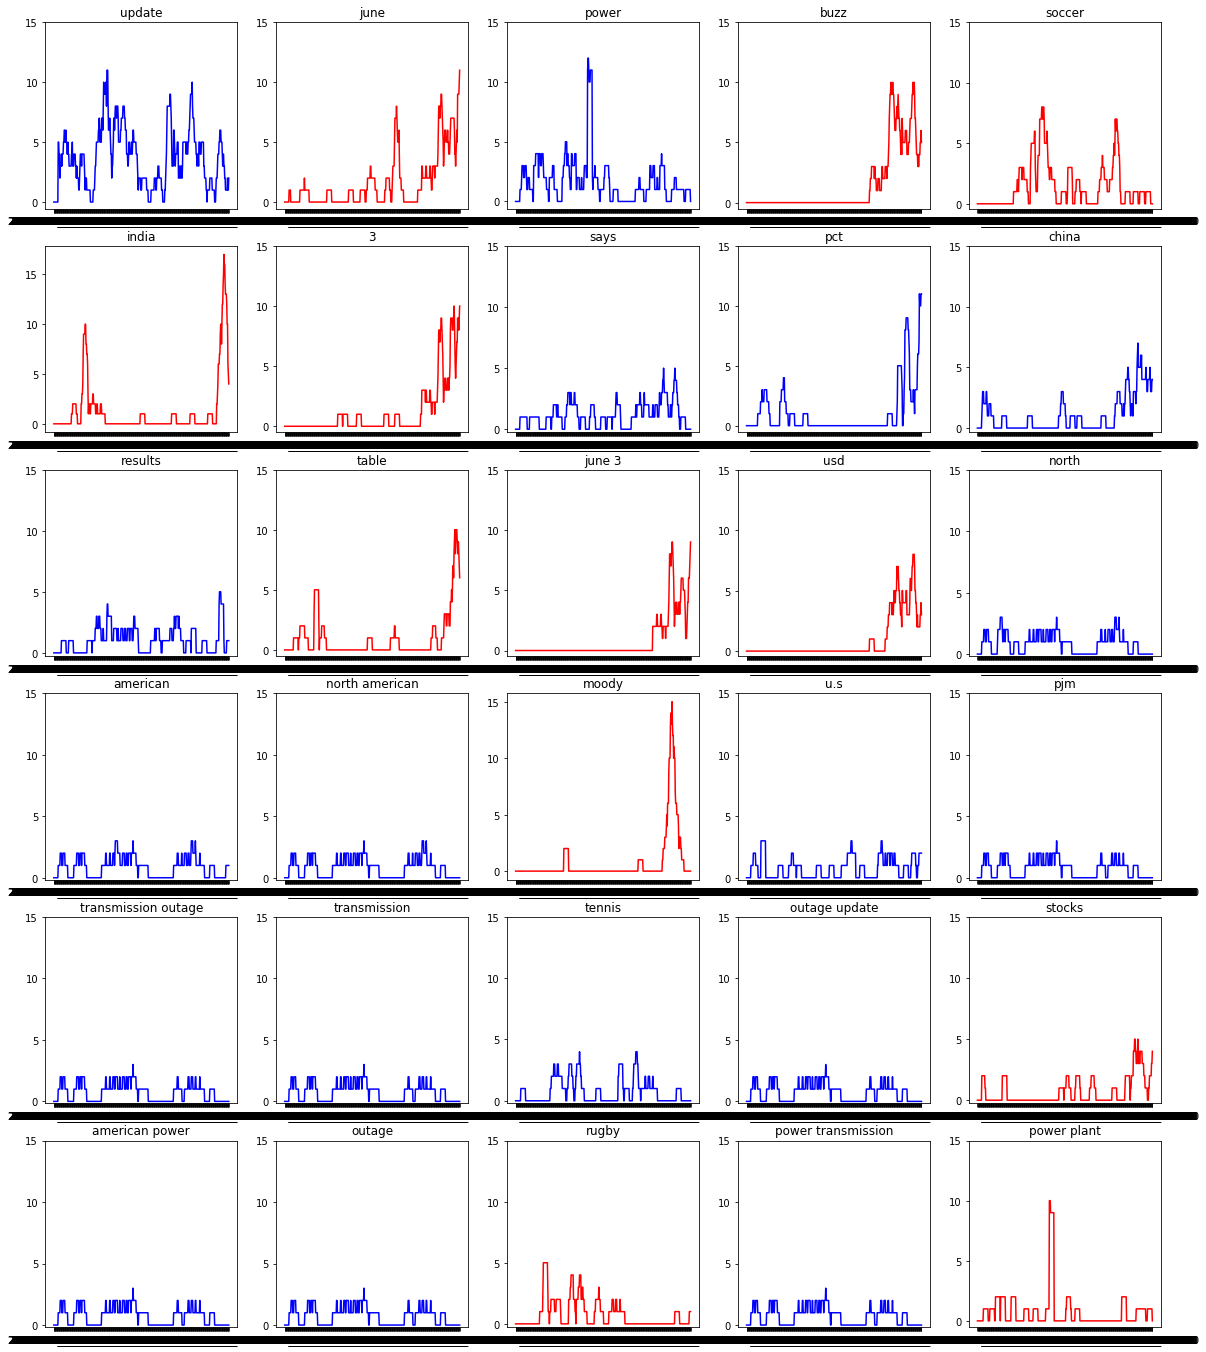

In [16]:
pp.make_plt(df_agg.rolling(12).sum().fillna(0),all_titles_vol,trending_titles_vol)

### Top 30 LDA topics
Finally, we have trained a LDA type model to observe any trends that go above single trending words. We have used 30 topics in the model but this can also be adjusted, however, the manually trained data only works with 30 topics

15 out of the 30 words here seem to match the description of a trending topic.

The below image shows each of those 30 terms against time and highlighing the ones in RED as trending (based on manual labelling). This approach is obviously subject to further discussion and what on those grids is onsidered a trend

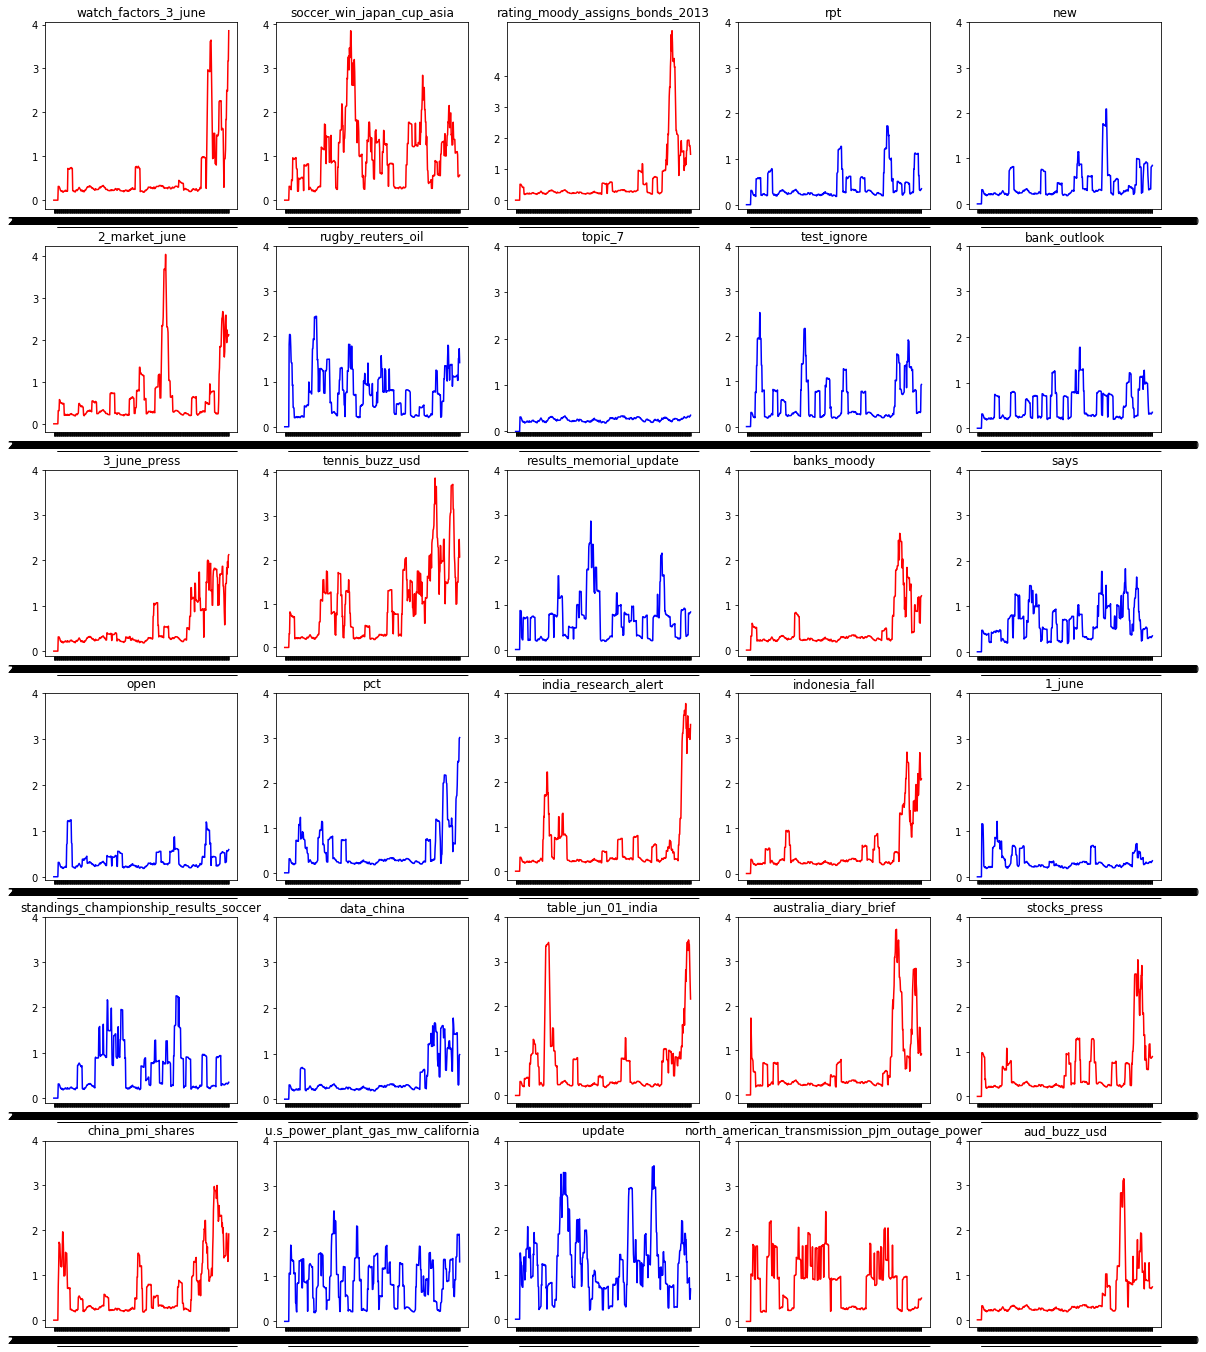

In [17]:
pp.make_plt(df_agg_lda.rolling(12).sum().fillna(0),all_titles_lda,trending_titles_lda, chart_scale=[4,5])

## Experiments
Experiments try to compare the performance of different:
- Vectorizers: count, tfidf, lda
- Applied on either article titles or body
For evaluation we use the sample hand labeled data from above. 

Metrics used are F1 & Accuracy. 
After reviewing results it seems that using LDA on both articles and titles for the evaluation provides a good balance between Accuracy and F1 metric


In [5]:
pt_top30='./ground_truth/Top30_wrds.csv'
pt_spk30='./ground_truth/Spike30_wrds.csv'
pt_lda30='./ground_truth/LDA30_tpcs.csv'
experiments= [
    ['HEADLINE_ALERT_TEXT','count','HEADLINE_ALERT_TEXT','count', pt_top30,pt_spk30],
    ['HEADLINE_ALERT_TEXT','count','HEADLINE_ALERT_TEXT','tfidf', pt_top30,pt_spk30],
    ['HEADLINE_ALERT_TEXT','count','ART_BODY_MERGED','tfidf', pt_top30,pt_spk30],
    ['HEADLINE_ALERT_TEXT','tfidf','ART_BODY_MERGED','tfidf', pt_top30,pt_spk30],
    ['HEADLINE_ALERT_TEXT','lda','ART_BODY_MERGED','count', pt_lda30],
    ['HEADLINE_ALERT_TEXT','lda','HEADLINE_ALERT_TEXT','tfidf', pt_lda30],
    ['HEADLINE_ALERT_TEXT','lda','ART_BODY_MERGED','tfidf', pt_lda30],
    ['HEADLINE_ALERT_TEXT','lda','HEADLINE_ALERT_TEXT','lda', pt_lda30],
    ['HEADLINE_ALERT_TEXT','lda','ART_BODY_MERGED','lda', pt_lda30],
            ]
    
    

In [6]:

for (i,exp) in enumerate(experiments):

    print(f"#{i}: Stationarity: {exp[0]} with {exp[1]} vectors, t-test: {exp[2]} with {exp[3]}")
    # pipe_ttl - Train Article titles Pipeline
    pipe_ttl=md.TrainPipe(col_nm=exp[0],vect_approach=exp[1])
    pipe_ttl.fit(df_unq_en,)
    
    # pipe_art - Train Article bodies Pipeline
    pipe_art=md.TrainPipe(col_nm=exp[2],vect_approach=exp[3])
    pipe_art.fit(df_unq_en,)

    for path in exp[4:]:
        # Loading ground truth data
        all_titles, trending_titles, y_true=ev.get_ground_truths(path)
        
        # Predict - Use the trainded pipelines to perform Dickey fuller test on the first pipeline 
        # and similarity comparison obetween all articles for a given a label, performa t-test to 
        # determine if statistically significant from the rest of the population
        pred_lbl, df_res=ev.pipe_predict(all_titles,df_unq_en, pipe_ttl,pipe_art, time_interval=5)

        # Evaluate accuracy and F1
        print('Evaluate dataset',
              path[3:].split('/')[1],
              'Accuracy',round(accuracy_score(pred_lbl,y_true),2),
              'F1',round(f1_score(pred_lbl,y_true),2),
              )

#0: Stationarity: HEADLINE_ALERT_TEXT with count vectors, t-test: HEADLINE_ALERT_TEXT with count
Evaluate dataset Top30_wrds.csv Accuracy 0.73 F1 0.67
Evaluate dataset Spike30_wrds.csv Accuracy 0.9 F1 0.93
#1: Stationarity: HEADLINE_ALERT_TEXT with count vectors, t-test: HEADLINE_ALERT_TEXT with tfidf
Evaluate dataset Top30_wrds.csv Accuracy 0.73 F1 0.67
Evaluate dataset Spike30_wrds.csv Accuracy 0.9 F1 0.93
#2: Stationarity: HEADLINE_ALERT_TEXT with count vectors, t-test: ART_BODY_MERGED with tfidf
Evaluate dataset Top30_wrds.csv Accuracy 0.73 F1 0.67
Evaluate dataset Spike30_wrds.csv Accuracy 0.9 F1 0.93
#3: Stationarity: HEADLINE_ALERT_TEXT with tfidf vectors, t-test: ART_BODY_MERGED with tfidf
Evaluate dataset Top30_wrds.csv Accuracy 0.73 F1 0.67
Evaluate dataset Spike30_wrds.csv Accuracy 0.9 F1 0.93
#4: Stationarity: HEADLINE_ALERT_TEXT with lda vectors, t-test: ART_BODY_MERGED with count
Evaluate dataset LDA30_tpcs.csv Accuracy 0.83 F1 0.84
#5: Stationarity: HEADLINE_ALERT_TEXT w